<a href="https://colab.research.google.com/github/fchang-smith/CSC370Planning/blob/main/Class_Activity_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: MNIST Digit Classification**
In the first portion of this lab, we will build and train a convolutional neural network (CNN) for classification of handwritten digits from the famous MNIST dataset. The MNIST dataset consists of 60,000 training images and 10,000 test images. Our classes are the digits 0-9.

First, let's import the relevant packages we'll need for this lab.

In [ ]:
# Import pyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm


Let's check that we are using a GPU.

In [ ]:
# Check that we are using a GPU, if not switch runtimes
# The program should print "cuda"
#   using Runtime > Change Runtime Type > GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
assert(device == 'cuda')
print(device)

cuda


# 1.1 MNIST dataset
Let's download and load the dataset using PyTorch's specific functions, such as Dataset and DataLoader, to handle loading data and labels. We can also define the batch size during this step.


In [ ]:
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/files/', train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor()
                             ])),
  batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/files/', train=False, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                             ])),
  batch_size=64, shuffle=True)


# Access the first batch of training data
example_iter = iter(train_loader)
example_images, example_labels = next(example_iter)

# You can print out the shape of a tensor by using variable.shape
print(f"example_images: {example_images.shape}")
print(f"example_labels: {example_labels.shape}")

example_images: torch.Size([64, 1, 28, 28])
example_labels: torch.Size([64])


Our training set is made up of 28x28 grayscale images of handwritten digits.

Let's visualize what some of these images and their corresponding training labels look like.

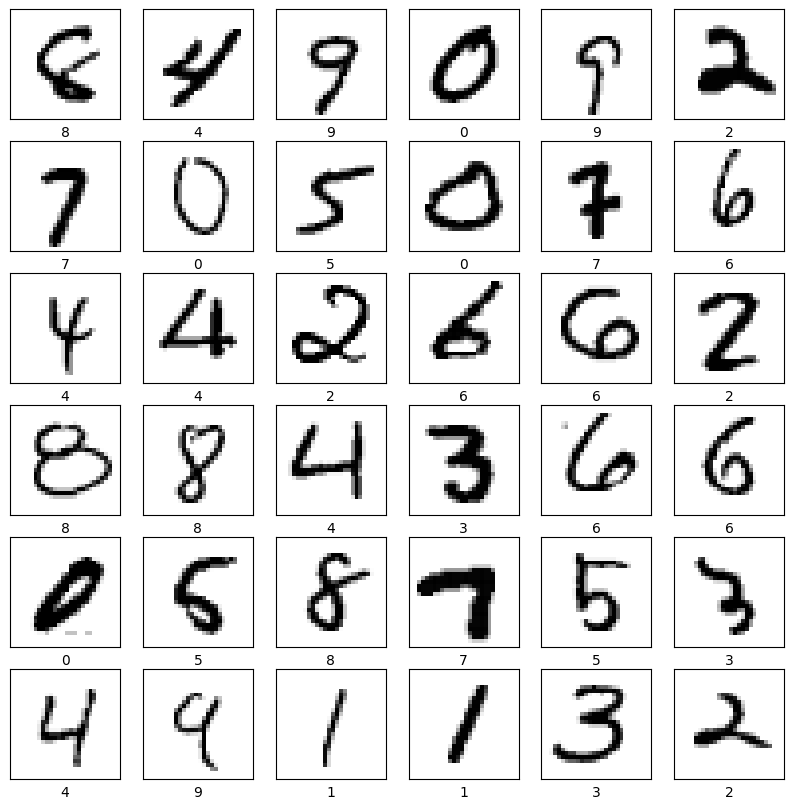

In [ ]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
  plt.subplot(6,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_ind = random_inds[i]
  plt.imshow(np.squeeze(example_images[i]), cmap=plt.cm.binary)
  plt.xlabel(example_labels[i].item())

# 1.2 Neural Network for Handwritten Digit Classification
We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 10 digit classes (0-9). This first architecture we will be building is depicted below:
![alt_text](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/mnist_2layers_arch.png "CNN Architecture for MNIST Classification")


### Fully connected neural network architecture
To define the architecture of this first fully connected neural network, we'll define the model using the `nn.Lnear` layer. Note how we first use a `nn.Flatten` layer, which flattens the input so that it can be fed into the model.

In this next block, you'll define the fully connected layers of this simple work.

In [ ]:
class mlp_model(nn.Module):
    def __init__(self):
        super(mlp_model, self).__init__()
        self.flatten = nn.Flatten()
        self.mlp1 = nn.Linear(784, 128)  # Adjust input size based on your data
        self.mlp2 = nn.Linear(128, 10)  # Adjust output size based on your task (e.g., number of classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.mlp1(x))
        x = F.softmax(self.mlp2(x), dim=1)
        return x

# Instantiate the model
model_1 = mlp_model()


Let's take a step back and think about the network we've just created. The first layer in this network, `nn.Flatten`, transforms the format of the images from a 2d-array (28 x 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. You can think of this layer as unstacking rows of pixels in the image and lining them up. There are no learned parameters in this layer; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `nn.Linear` layers. These are fully-connected neural layers. The first `Linear` layer has 128 nodes (or neurons). The second (and last) layer (which you've defined!) should return an array of probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the handwritten digit classes.

That defines our fully connected model!

### Train the model

We're now ready to train our model, which will involve feeding the training data (`train_images` and `train_labels`) into the model, and then asking it to learn the associations between images and labels. We'll also need to define the number of epochs, or iterations over the MNIST dataset, to use during training.

We'll use a stochastic gradient descent (SGD) optimizer initialized with a learning rate of 0.1. Since we are performing a categorical classification task, we'll want to use the cross entropy loss.

In [ ]:
# Set up key parameters
num_epoch = 5
learning_rate = 0.1
momentum = 0.5
log_interval = 100
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate, momentum = momentum)

# Using array to keep track of the loss
loss_array = []

# Training loop
# During each epoch, the model is trained on the entire dataset
for epoch in range(num_epoch):
  model_1.train() # Set up trainning mode
  train_iter = iter(train_loader)

  # loop over all batches in the dataloader
  for train_idx, (train_images, train_labels) in enumerate(train_iter):
    pred = model_1.forward(train_images) # Use the model to predict the label
    loss = loss_function(pred, train_labels) # Compute loss
    loss.backward() # Backpropogation
    optimizer.step() # Modify the learning rate based on the optimizer's algorithm
    optimizer.zero_grad()
    loss_array.append(loss.item())

    # Print out metrics very 100 batches
    if train_idx % log_interval == 0: # Remind: log_interval = 100
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch+1, train_idx * len(train_images), len(train_loader.dataset),
        100. * train_idx / len(train_loader), loss.item()))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302731
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.121185
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.763762
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.709282
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.729475
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.682177
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.600190
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.611730
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.633219
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.644815
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.589657
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.582284
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.576712
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.562819
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.545126
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.528446
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.547755
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.540102
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.580447
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.539253
Train Epoch:

### Evaluate accuracy on the test dataset

Now that we've trained the model, we can ask it to make predictions about a test set that it hasn't seen before. In this example, the `test_images` array comprises our test dataset. To evaluate accuracy, we can check to see if the model's predictions match the labels from the `test_labels` array.


In [ ]:
model_1.eval() # Set up the evaluation mode
test_loss = 0
correct = 0
with torch.no_grad():
  # Loop over the test dataset only once
  for test_images, test_labels in test_loader:
    pred = model_1(test_images)
    test_loss += F.nll_loss(pred, test_labels, size_average=False).item()
    pred = pred.data.max(1, keepdim=True)[1]
    correct += pred.eq(test_labels.data.view_as(pred)).sum() # Compare labels and predictions
test_loss /= len(test_loader.dataset)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  test_loss, correct, len(test_loader.dataset),
  100. * correct / len(test_loader.dataset)))

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: -0.9284, Accuracy: 9380/10000 (94%)



What is the highest accuracy you can achieve with this first fully connected model? Since the handwritten digit classification task is pretty straightforward, you may be wondering how we can do better...

## 1.3 Convolutional Neural Network (CNN) for handwritten digit classification

Convolutional neural networks (CNNs) are particularly well-suited for a variety of tasks in computer vision, and have achieved near-perfect accuracies on the MNIST dataset. We will now build a CNN composed of two convolutional layers and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9). The CNN we will be building is depicted below:

![CNN Architecture for MNIST Classification](https://raw.githubusercontent.com/fchang-smith/CSC370Planning/main/cnn_structure.jpg "CNN Architecture for MNIST Classification")


### Define the CNN model

We'll use the same training and test datasets as before, and proceed similarly as our fully connected network to define and train our new CNN model. To do this we will explore two layers we have not encountered before: you can use  `nn.Conv2d` to define convolutional layers and `nn.MaxPool2d` to define the pooling layers. Use the parameters shown in the network architecture above to define these layers and build the CNN model.

In [ ]:
class cnn_model(nn.Module):
  def __init__(self):
    super(cnn_model, self).__init__()
    # TODO: Define the first convolutional layer
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
    self.flatten = nn.Flatten()
    self.mlp1 = nn.Linear(320, 50)
    self.mlp2 = nn.Linear(50, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.mlp1(x)
    x = F.relu(x)
    x = self.mlp2(x)
    x = F.log_softmax(x)
    return x
    # you can also write it as:
    # x = self.pool1(F.relu(self.con1(x)))
    # x = self.pool2(F.relu(self.con2(x)))
    # x = self.flatten(x)
    # x = F.relu(self.mlp1(x))
    # x = F.log_softmax(self.mlo2(x))

# Create an instance of the CNN model
model_2 = cnn_model()

# Print the summary of the layers in the model
print(model_2)

cnn_model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp1): Linear(in_features=320, out_features=50, bias=True)
  (mlp2): Linear(in_features=50, out_features=10, bias=True)
)


### Train and test the CNN model

Now, as before, we can define the loss function, optimizer, and calculate accuracy.
Basically, the only difference between this training loop and the multiple percepton (mlp) trainning loop is that model_1 is substituted with model_2.



In [ ]:
 # Set up key parameters
num_epoch = 5
learning_rate = 0.1
momentum = 0.5
log_interval = 100
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate, momentum = momentum)

# Using array to keep track of the loss
train_losses = []
train_counter = []

# Training loop
# During each epoch, the model is trained on the entire dataset
for epoch in range(num_epoch):
  model_2.train() # Set up trainning mode
  train_iter = iter(train_loader)
  # loop over all batches in the dataloader
  for train_idx, (train_images, train_labels) in enumerate(train_iter):
    pred = model_2.forward(train_images) # Use the model to predict the label
    loss = loss_function(pred, train_labels) # Compute loss
    loss.backward() # Backpropogation
    optimizer.step() # Modify the learning rate based on the optimizer's algorithm
    optimizer.zero_grad()

    if train_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch+1, train_idx * len(train_images), len(train_loader.dataset),
        100. * train_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((train_idx*64) + ((epoch)*len(train_loader.dataset)))

<ipython-input-22-8a86c1278aa8>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 1.605970
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.588723
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.610916
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.531644


KeyboardInterrupt: 

As before, let's test the model and calculate the accuracy.

In [ ]:
model_2.eval()
test_loss = 0
correct = 0
with torch.no_grad():
  for test_images, test_labels in test_loader:
    pred = model_2(test_images)
    test_loss += F.nll_loss(pred, test_labels, size_average=False).item()
    pred = pred.data.max(1, keepdim=True)[1]
    correct += pred.eq(test_labels.data.view_as(pred)).sum()
test_loss /= len(test_loader.dataset)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  test_loss, correct, len(test_loader.dataset),
  100. * correct / len(test_loader.dataset)))

<ipython-input-13-e2ebaa44af56>:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0383, Accuracy: 9880/10000 (99%)



We can vitualize the loss descending process.

Text(0, 0.5, 'negative log likelihood loss')

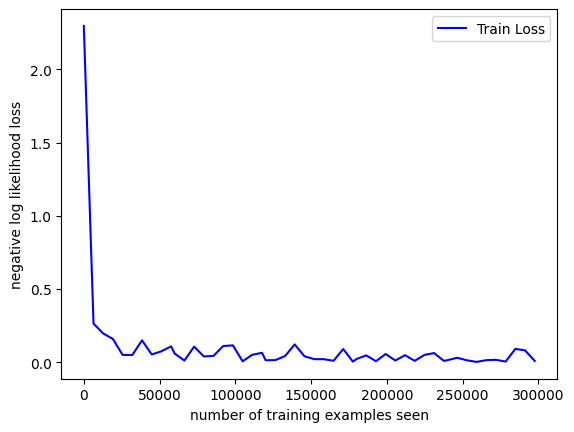

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

# A failed example
The model below is too complex that it does not perform well. You can try it yourself by uncommenting everything in the cell below.

![alt_text](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/convnet_fig.png "CNN Architecture for MNIST Classification")

In [ ]:
class cnn_model(nn.Module):
  def __init__(self):
    super(cnn_model, self).__init__()
    self.conv1 = nn.Conv2d(1, 24, kernel_size=(3, 3), stride=1, padding=0)
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
    self.conv2 = nn.Conv2d(24, 36, kernel_size=(3, 3), stride=1, padding=0)
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
    self.flatten = nn.Flatten()
    self.mlp1 = nn.Linear(36 * 5 * 5, 128)
    self.mlp2 = nn.Linear(128, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x)) # output size: 24 * 26 * 26
    x = self.pool1(x) # output size: 24 * 13 * 13
    x = F.relu(self.conv2(x)) # output size: 36 * 11 * 11
    x = self.pool2(x) # output size: 36 * 5 * 5
    x = self.flatten(x) # output size: 900
    x = F.relu(self.mlp1(x))
    x = self.mlp2(x)
    return F.softmax(x, dim=0)